In [1]:
#Data Pre-processing part
import os
import random
import pandas as pd

In [4]:
from datasets import load_dataset

dataset = load_dataset("google/fleurs",'hi_in')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 2120
    })
    validation: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 239
    })
    test: Dataset({
        features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
        num_rows: 418
    })
})

In [8]:
word_lentgh = []
sum=0
for sentence in dataset['test']['transcription']:
    word_lentgh.append(len(sentence.split()))
    sum+=len(sentence.split())

sum/len(dataset['test'])

24.507177033492823

In [276]:
# new tokenizer
from tokenizers import (decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer)
from transformers import GPT2Tokenizer, GPT2TokenizerFast, GPT2Model, GPT2LMHeadModel
from transformers import TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

new_tokenizer = Tokenizer(models.BPE())
new_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
trainer = trainers.BpeTrainer(vocab_size=3000, special_tokens=["<|endoftext|>"])
# train_file = 'fleurs_train.txt'
train_file = 'kathbath/kb_data_clean_wav/gujarati/all_text.txt'
new_tokenizer.train([train_file], trainer=trainer)
new_tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
new_tokenizer.decoder = decoders.ByteLevel()
new_tokenizer = GPT2TokenizerFast(tokenizer_object=new_tokenizer)
new_tokenizer.save_pretrained("new_tokenizer_gpt2")
new_tokenizer

GPT2TokenizerFast(name_or_path='', vocab_size=3000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [279]:
# gpt2 tokenizer
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
print(len(gpt2_tokenizer.get_vocab()))
gpt2_tokenizer

# merge the vocabulary for the extended tokenizer
vocab_tokens = list(new_tokenizer.get_vocab())
decoded_tokens = [new_tokenizer.decoder.decode([token]) for token in vocab_tokens]
print(len(vocab_tokens), len(decoded_tokens))
gpt2_tokenizer.add_tokens(decoded_tokens)
gpt2_tokenizer.save_pretrained("extended_tokenizer_gpt2")
print(len(gpt2_tokenizer.get_vocab()))
gpt2_tokenizer

# validate the changes
text = "अनुराग 1972 में निर्मित एक हिन्दी फ़िल्म"
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
new_tokenizer = GPT2TokenizerFast.from_pretrained("new_tokenizer_gpt2")
extended_tokenizer = GPT2TokenizerFast.from_pretrained("extended_tokenizer_gpt2")

print(len(gpt2_tokenizer.encode(text)))
print(gpt2_tokenizer.encode(text))
print(len(new_tokenizer.encode(text)))
print(new_tokenizer.encode(text))
print(len(extended_tokenizer.encode(text)))
print(extended_tokenizer.encode(text))

50257
3000 3000
53199


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


60
[11976, 227, 11976, 101, 24231, 223, 11976, 108, 48077, 11976, 245, 16101, 28225, 106, 24231, 229, 11976, 224, 28225, 101, 11976, 123, 11976, 108, 24231, 235, 11976, 106, 11976, 123, 11976, 97, 28225, 237, 11976, 243, 28225, 117, 11976, 123, 11976, 101, 24231, 235, 11976, 99, 24231, 222, 28225, 104, 11976, 120, 11976, 123, 11976, 110, 24231, 235, 11976, 106]
96
[25, 4, 32, 25, 4, 8, 25, 5, 29, 25, 4, 14, 25, 4, 23, 25, 4, 48, 27, 27, 25, 4, 12, 25, 5, 34, 25, 4, 30, 27, 25, 4, 8, 25, 4, 24, 25, 4, 14, 25, 5, 40, 25, 4, 12, 25, 4, 24, 25, 4, 4, 27, 25, 4, 41, 25, 4, 46, 27, 25, 4, 21, 25, 4, 24, 25, 4, 8, 25, 5, 40, 25, 4, 6, 25, 5, 28, 27, 25, 4, 10, 25, 4, 22, 25, 4, 24, 25, 4, 15, 25, 5, 40, 25, 4, 12]
66
[11976, 227, 11976, 101, 24231, 223, 11976, 108, 48077, 11976, 245, 51902, 41023, 51902, 11976, 106, 24231, 229, 11976, 224, 51902, 11976, 101, 11976, 123, 11976, 108, 24231, 235, 11976, 106, 11976, 123, 11976, 97, 51902, 11976, 237, 11976, 243, 51902, 11976, 117, 11976, 123, 119

In [280]:
from transformers import WhisperFeatureExtractor

model_path = "openai/whisper-large-v3"

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_path)

In [281]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_path, language="Gujarati", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [282]:
tokenizer.add_tokens(decoded_tokens)

2942

In [283]:
print(len(tokenizer.get_vocab()))

54808


In [284]:
input_str = dataset["train"][0]["transcription"]

# prompt = "IndoAryan"
# prompt_ids = tokenizer.get_prompt_ids(prompt)

labels = tokenizer(input_str).input_ids

# tokenizer = WhisperTokenizer.from_pretrained(model_path, language="Bengali", task="transcribe")
# tokenizer.add_tokens(decoded_tokens)
# labels = [51, 71, 72, 82, 53552, 82, 53869, 340, 2455, 83, 50257]

decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 ક્રાઉન ઑફિસ જે ફરિયાદની કાર્યવાહીની એકંદર નિયંત્રણકર્તા છે તેણે પત્રકારોને જણાવ્યું છે કે જ્યાં સુધી તહોમતનામું નહીં બને ત્યાં સુધી કોઈ ટિપ્પણી કરવામાં નહીં આવે
Decoded w/ special:    <|startoftranscript|><|gu|><|transcribe|><|notimestamps|>ક્રાઉન ઑફિસ જે ફરિયાદની કાર્યવાહીની એકંદર નિયંત્રણકર્તા છે તેણે પત્રકારોને જણાવ્યું છે કે જ્યાં સુધી તહોમતનામું નહીં બને ત્યાં સુધી કોઈ ટિપ્પણી કરવામાં નહીં આવે<|endoftext|>
Decoded w/out special: ક્રાઉન ઑફિસ જે ફરિયાદની કાર્યવાહીની એકંદર નિયંત્રણકર્તા છે તેણે પત્રકારોને જણાવ્યું છે કે જ્યાં સુધી તહોમતનામું નહીં બને ત્યાં સુધી કોઈ ટિપ્પણી કરવામાં નહીં આવે
Are equal:             True


In [285]:
dataset['train'][0]

{'id': 1252,
 'num_samples': 211200,
 'path': '/raid/speech/rajgothi/.cache/huggingface/datasets/downloads/extracted/08f08409e536e1597bee38a241cf159e5498245ea9b1348fb3108ed965d80a7d/10001270418144802497.wav',
 'audio': {'path': 'train/10001270418144802497.wav',
  'array': array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.7362833e-04,
         1.1152029e-04, 7.2658062e-05]),
  'sampling_rate': 16000},
 'transcription': 'ક્રાઉન ઑફિસ જે ફરિયાદની કાર્યવાહીની એકંદર નિયંત્રણકર્તા છે તેણે પત્રકારોને જણાવ્યું છે કે જ્યાં સુધી તહોમતનામું નહીં બને ત્યાં સુધી કોઈ ટિપ્પણી કરવામાં નહીં આવે',
 'raw_transcription': 'ક્રાઉન ઑફિસ, જે ફરિયાદની કાર્યવાહીની એકંદર નિયંત્રણકર્તા છે તેણે પત્રકારોને જણાવ્યું છે કે જ્યાં સુધી તહોમતનામું નહીં બને ત્યાં સુધી કોઈ ટિપ્પણી કરવામાં નહીં આવે.',
 'gender': 1,
 'lang_id': 29,
 'language': 'Gujarati',
 'lang_group_id': 4}

In [286]:
train_path = dataset['train']['path']
new_path = []
for path in train_path:
    path = path.split('/')
    path = '/'.join(path[:-1]) + '/train/' + path[-1]
    new_path.append(path)

dataset['train'] = dataset['train'].remove_columns(['path'])
dataset['train'] = dataset['train'].add_column("path", new_path)

dev_path = dataset['validation']['path']
new_path = []
for path in dev_path:
    path = path.split('/')
    path = '/'.join(path[:-1]) + '/dev/' + path[-1]
    new_path.append(path)

dataset['validation'] = dataset['validation'].remove_columns(['path'])
dataset['validation'] = dataset['validation'].add_column("path", new_path)


test_path = dataset['test']['path']
new_path = []
for path in test_path:
    path = path.split('/')
    path = '/'.join(path[:-1]) + '/test/' + path[-1]
    new_path.append(path)

dataset['test'] = dataset['test'].remove_columns(['path'])
dataset['test'] = dataset['test'].add_column("path", new_path)

In [287]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_path, language="Gujarati", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [288]:
from datasets import Audio

dataset = dataset.cast_column("path", Audio(sampling_rate=16000))
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'path'],
        num_rows: 3145
    })
    validation: Dataset({
        features: ['id', 'num_samples', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'path'],
        num_rows: 432
    })
    test: Dataset({
        features: ['id', 'num_samples', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'path'],
        num_rows: 1000
    })
})

In [289]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["path"]

    # compute log-Mel input features from input audio array 
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids 
    batch["labels"] = tokenizer(batch["transcription"]).input_ids
    return batch

In [290]:
dataset['test'] = dataset['test'].map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=64)

Map (num_proc=64):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [291]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'num_samples', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'path'],
        num_rows: 3145
    })
    validation: Dataset({
        features: ['id', 'num_samples', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id', 'path'],
        num_rows: 432
    })
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 1000
    })
})

In [293]:
test_token_length = []
sum= 0 
for label in dataset['test']['labels']:
    test_token_length.append(len(label))
    sum+=len(label)

avg = sum/len(dataset['test'])
avg

89.214

Hindi:

WhisperTokenizer : 133.24 average token length...

our tokenizer with additional vocab size of 100: 123.96

our tokenizer with additional vocab size of 300: 91.71

our tokenizer with additional vocab size of 500: 88.87

our tokenizer with additional vocab size of 1000: 86.55

our tokenizer with additional vocab size of 2000: 85.64

our tokenizer with additional vocab size of 3000: 85.58

Gujarati:

WhisperTokenizer : 322.675 average token length...

our tokenizer with additional vocab size of 100: 133.96

our tokenizer with additional vocab size of 300: 96.062

our tokenizer with additional vocab size of 500: 93.323

our tokenizer with additional vocab size of 1000: 90.74

our tokenizer with additional vocab size of 2000: 89.509

our tokenizer with additional vocab size of 3000: 89.214

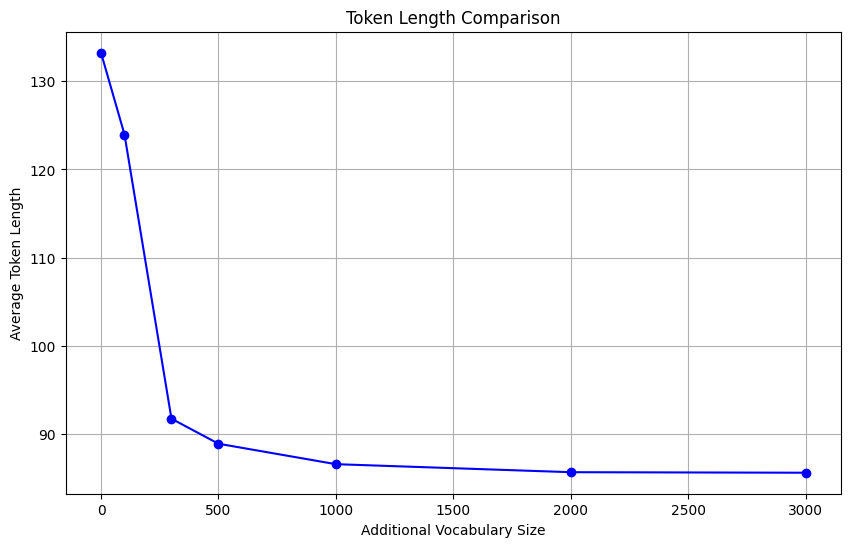

In [294]:
import matplotlib.pyplot as plt

# Data
additional_vocab_sizes = [0, 100, 300, 500, 1000, 2000, 3000]
token_lengths = [133.24, 123.96, 91.71, 88.87, 86.55, 85.64, 85.58]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(additional_vocab_sizes, token_lengths, marker='o', color='b', linestyle='-')

# Add labels and title
plt.xlabel('Additional Vocabulary Size')
plt.ylabel('Average Token Length')
plt.title('Token Length Comparison')

# Show grid
plt.grid(True)

# Show plot
plt.show()


In [22]:
# dataset['test']['labels'][0]

418

In [18]:
test_token_length

[124,
 204,
 152,
 80,
 121,
 125,
 227,
 84,
 98,
 196,
 183,
 129,
 107,
 135,
 195,
 140,
 140,
 218,
 100,
 88,
 176,
 168,
 120,
 175,
 167,
 99,
 66,
 71,
 264,
 129,
 174,
 173,
 125,
 72,
 91,
 104,
 90,
 100,
 197,
 209,
 84,
 153,
 117,
 153,
 140,
 74,
 100,
 124,
 153,
 122,
 90,
 118,
 268,
 125,
 173,
 74,
 212,
 117,
 173,
 84,
 103,
 152,
 98,
 100,
 77,
 82,
 143,
 82,
 130,
 175,
 118,
 101,
 73,
 218,
 279,
 118,
 182,
 134,
 178,
 145,
 139,
 218,
 196,
 147,
 134,
 404,
 174,
 141,
 140,
 101,
 165,
 200,
 85,
 112,
 129,
 148,
 175,
 127,
 125,
 128,
 214,
 83,
 122,
 139,
 109,
 164,
 157,
 115,
 139,
 220,
 175,
 115,
 139,
 110,
 111,
 175,
 177,
 164,
 87,
 176,
 109,
 135,
 51,
 181,
 91,
 107,
 104,
 117,
 144,
 215,
 156,
 111,
 130,
 62,
 197,
 134,
 268,
 139,
 130,
 161,
 152,
 103,
 128,
 110,
 137,
 104,
 192,
 130,
 88,
 57,
 116,
 207,
 127,
 112,
 218,
 151,
 91,
 130,
 115,
 83,
 267,
 82,
 119,
 152,
 120,
 91,
 78,
 156,
 154,
 227,
 71,
 147,
 1

In [78]:
dataset['test'][0]

{'input_features': [[-0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.6870378255844116,
   -0.7056783437728882,
   -0.7967410087585449,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004

In [104]:
dataset['test'][0]

{'input_features': [[-0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.6870378255844116,
   -0.7056783437728882,
   -0.7967410087585449,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004,
   -0.8028244972229004

In [79]:
dataset.save_to_disk('Dataset/hindi_original')

Saving the dataset (0/7 shards):   0%|          | 0/2120 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/239 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/418 [00:00<?, ? examples/s]

In [80]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 2120
    })
    validation: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 239
    })
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 418
    })
})